In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import shap
import joblib

In [4]:
# ---------- 1. LOAD DATA ----------
df = pd.read_excel('data.xls')

In [5]:
# Quick look
print(df.shape)
print(df.columns)

(9994, 21)
Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')


In [7]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/pplonski/datasets-for-start/master/employee_attrition/HR-Employee-Attrition-All.csv')
print(df.columns.tolist())


['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EmployeeCount', 'EmployeeNumber', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'Over18', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


In [8]:
df['AttritionFlag'] = df['Attrition'].map({'Yes': 1, 'No': 0})


In [9]:
# Feature-target split
X = df.drop(columns=['Attrition', 'AttritionFlag'])
y = df['AttritionFlag']

In [10]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
# Identify feature types
numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [13]:
# Preprocessing pipeline
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))])


preprocessor = ColumnTransformer([
('num', num_transformer, numeric_features),
('cat', cat_transformer, categorical_features)
])

In [14]:
# Model pipeline
clf = DecisionTreeClassifier(random_state=42)
pipe = Pipeline(steps=[('pre', preprocessor), ('clf', clf)])

In [17]:
# Hyperparameter tuning
param_grid = {
'clf__max_depth': [3, 5, 7, 9, None],
'clf__min_samples_split': [2, 5, 10]
}


grid = GridSearchCV(pipe, param_grid, cv=5, scoring='f1', n_jobs=1)
grid.fit(X_train, y_train)


best_model = grid.best_estimator_
print('Best parameters:', grid.best_params_)

Best parameters: {'clf__max_depth': None, 'clf__min_samples_split': 2}


In [19]:
# Predictions
y_pred = best_model.predict(X_test)

In [20]:
# Evaluation
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))
print('\nClassification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.7789115646258503
Precision: 0.3269230769230769
Recall: 0.3617021276595745
F1 Score: 0.3434343434343434

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87       247
           1       0.33      0.36      0.34        47

    accuracy                           0.78       294
   macro avg       0.60      0.61      0.61       294
weighted avg       0.79      0.78      0.78       294



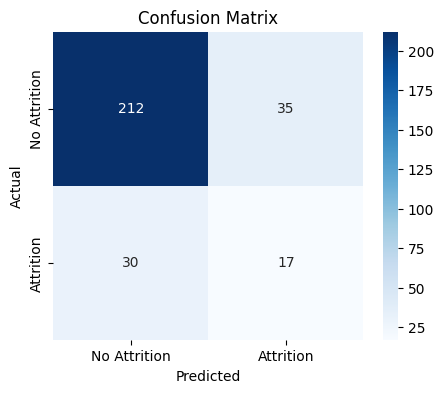

In [26]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Attrition', 'Attrition'], yticklabels=['No Attrition', 'Attrition'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Save + Show
plt.savefig('confusion_matrix.png', bbox_inches='tight')
plt.show()

In [27]:
# SHAP Explainability
explainer = shap.Explainer(best_model.named_steps['clf'], best_model.named_steps['pre'].transform(X_train))
X_test_trans = best_model.named_steps['pre'].transform(X_test)
shap_values = explainer(X_test_trans)


shap.summary_plot(shap_values, X_test_trans, show=False)
plt.savefig('shap_summary.png', bbox_inches='tight')
plt.close()

In [28]:


# Save model and report
joblib.dump(best_model, 'hr_attrition_model.joblib')
with open('classification_report.txt', 'w') as f:
    f.write(classification_report(y_test, y_pred))


print('Model, confusion matrix, and SHAP plots saved successfully!')

Model, confusion matrix, and SHAP plots saved successfully!
